In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy as sp
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
%matplotlib inline
import sys 
sys.path.append('/Users/jeffrey/GoogleDrive/PulsarSignalSimulator/PulsarSimulator/')
import VersionZeroPointZero as PSS
from scipy import signal

I incorporated your changes, but there were a few typos that I fixed. Some of the pulsar_object and signal_object calls were mixed up, and the syntax for creating the dictionary was incorrect I think.

In [4]:
def DMBroaden(pulsar_object, signal_object, to_DM_Broaden=True):
    dm_widths = np.zeros(pulsar_object.Nf)
    for ii, freq in enumerate(pulsar_object.Signal_in.freq_Array):
        sub_band_width = pulsar_object.bw/pulsar_object.Nf
        width = int(PSS.utils.top_hat_width(sub_band_width, freq, 100)//pulsar_object.TimeBinSize)
        if width > pulsar_object.Nt:
            raise ValueError('Too Much DM! Dispersion broadening top hat wider than data array!')
        dm_widths[ii] = width
        pulsar_object.profile[ii,:] = sp.convolve(pulsar_object.profile[ii,:], signal.boxcar(width)/width,'same')
    Dict = {'dm_widths':dm_widths}
    signal_object.MetaData.AddInfo(Dict)

Initializing signal, pulse, and ISM.

In [7]:
S1=PSS.Signal(Nt=2000,mode='simulate')
P1=PSS.Pulsar(S1)
I1=PSS.ism.ISM(S1,mode='simulate')
PSS.ism.ISM.finalize_ism(I1)

Just specifying the gaussians to make the plots in this notebook nicer, that way the broadening is more obvious.

In [8]:
peak3 = np.random.randn(20*3)*0.01 + 0.2
width3 = abs(np.random.randn(20*3)*0.002 +0.012)
amp3 = np.random.randn(20*3)**2
peak3.resize(20,3)
width3.resize(20,3)
amp3.resize(20,3)
P1.gauss_template(peak=peak3,width=width3,amp=amp3)

In [9]:
DMBroaden(P1,S1) #Running the method. Make sure to include both the pulse and the signal.

In [10]:
P1.make_pulses()

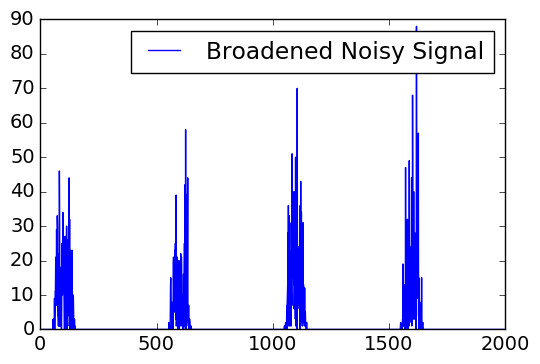

In [11]:
plt.plot(P1.signal[5],label="Broadened Noisy Signal")
plt.legend()
plt.show()


In [12]:
# I'll put this little gem into the simulator when I have a chance... 
def ProfilePlot(array, step=1, N=10,Title='Profile by Frequency Channel'):
    try:
        array_len = len(N)
        jj = 0
        for ii, jj in enumerate(N):
            plot(array[jj,:]+ii*(step),c='k')
        n=len(N)
    except:
        Freq_channels = len(array[:,0])
        Freq_step = int(Freq_channels//N)
        for ii in range(N):
            plot(array[ii*Freq_step,:]+ii*(step),c='k')
        n=N
    title(Title)
    xlabel('Phase')
    ylabel('Frequency Channel')
    xticks([])
    yticks([])
    xlim(0,len(array[0,:]))
    ylim(0,n*step+0.1)
    show()

__Cassidy:__ The above method just plots each of the profiles in the same line plot. The lowest frequency channel is at the bottom, highest at the top. 

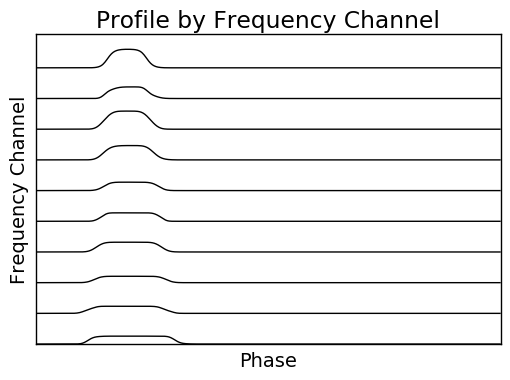

In [14]:
ProfilePlot(P1.profile)

# Working on convolving with an exponential

Define the function that convolves with an exponential

In [31]:
del S1, P1, I1

In [57]:
S2=PSS.Signal(Nt=2000,mode='simulate')
P2=PSS.Pulsar(S2)
I2=PSS.ISM(S2,mode='simulate')
I2.finalize_ism() 

__Cassidy:__ I just made a second signal and removed the first from memory, so that we can start fresh for the next signal. Also, note the last command, `I2.finalize_ism()` can be called this way, instead of the more complicated way you called it the first time. 

In [58]:
def Scintillation(pulsar_object, signal_object):
    width=499
    N_Tau=10
    tau_scatter=PSS.scintillation.scale_tau_d(tau_d=10,nu_i=600,nu_f=signal_object.freq_Array)
    for i in tau_scatter:
        t = np.linspace(0,N_Tau*i,width)
        EXP=(np.exp(-t/i))
        EXP_sum = np.sum(EXP)
        EXP_norm = EXP / EXP_sum
        global EXP_func
        EXP_func=np.asarray(EXP)
    for ii, freq in enumerate(pulsar_object.Signal_in.freq_Array):
        pulsar_object.profile[ii,:] = sp.convolve(pulsar_object.profile[ii,:], EXP_func,'same')

__Cassidy:__ I really like how you vectorized the `tau_scatter` array. I think you'll want to make the `tau_d` that goes into the `scale_tau_d()` method a parameter that goes into the function, because we'll want to be able to change it. Do you know what units it should be in? Will we need to change `width` and `N_Tau`? I think you can meld together your `for` loops. There are the same number of `i`'s in `signal_object.freq_array` as there are `ii`'s in `pulsar_object.Signal_in.freq_Array`. In fact they are the same, so it might be better to only refer to one for ease of understanding (for someone else reading the code). I would defer to using the `signal_object` when possible. 

In [59]:
P2.make_pulses()

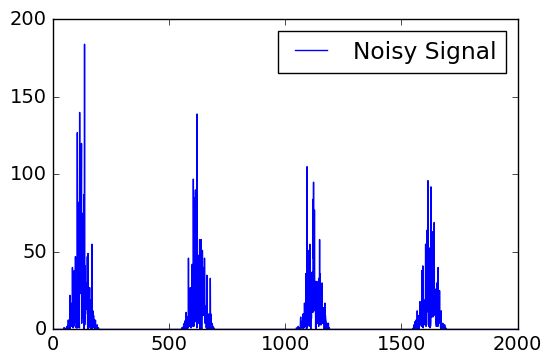

In [60]:
plt.plot(P2.signal[5],label="Noisy Signal")
plt.legend()
plt.show()

In [61]:
DMBroaden(P2,S2)
Scintillation(P2,S2)

In [62]:
P2.make_pulses()

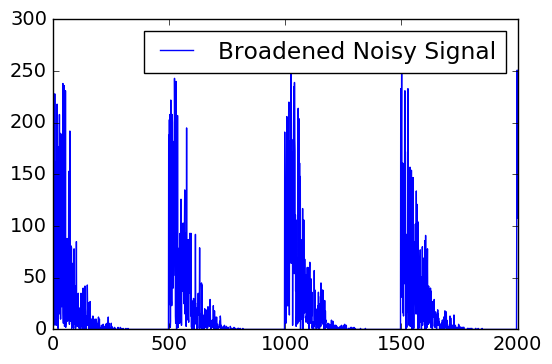

In [63]:
plt.plot(P2.signal[5],label="Broadened Noisy Signal")
plt.legend()
plt.show()

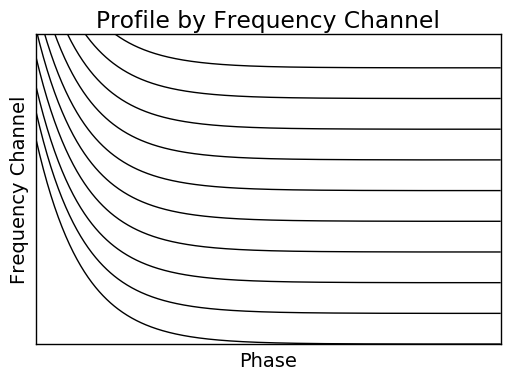

In [64]:
ProfilePlot(P2.profile)

__Cassidy:__ It looks like the exponential convolution has completely obliterated the pulse shape at all. I'm sure you've seen the figures in the Pulsar Handbook of scatter broadening. These should look like gaussians with extended tails. It's probably that we have put in some unphysical size for the parameters. You'll need to choose `width`, `N_tau` and `tau_d` so that they are reasonable choices for the time sampling rate and pulse width of the signal intialized. 